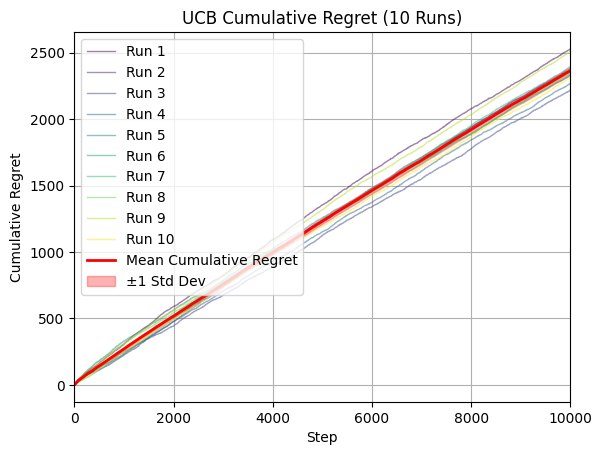

✅ Total execution time: 14.47 seconds


In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import os

# Load preprocessed data
def load_preprocessed_data(save_path="./save"):
    with open(os.path.join(save_path, "arms.json"), "r") as f:
        arms = json.load(f)
    with open(os.path.join(save_path, "rewards.json"), "r") as f:
        rewards = json.load(f)
    return arms, rewards

# UCB strategy
def ucb_bandit(K, n, reward_lists, B):
    np.random.seed(int(time.time()))
    random.seed(time.time())

    rewards, choices, regrets = [], [], []
    empirical_means = np.zeros(K)
    action_counts = np.zeros(K)
    cumulative_regrets = np.zeros(n)

    for t in range(1, n + 1):
        ucb_values = empirical_means + (B / 2) * np.sqrt((4 * np.log(t)) / (action_counts + 1e-5))
        arm = np.argmax(ucb_values)
        r = random.choice(reward_lists[arm])

        rewards.append(r)
        choices.append(arm)
        action_counts[arm] += 1
        empirical_means[arm] = (empirical_means[arm] * (action_counts[arm] - 1) + r) / action_counts[arm]

        best_arm_mean = np.max(empirical_means)
        regrets.append(best_arm_mean - r)
        cumulative_regrets[t - 1] = np.sum(regrets)

    return cumulative_regrets

# -------------------------
# Add timing start
# -------------------------
start_time = time.time()

# Load preprocessed data
arms, rewards = load_preprocessed_data()
reward_lists = list(rewards.values())
K = len(arms)
B = 5
n = 10000
num_runs = 10
all_cumulative_regrets = np.zeros((num_runs, n))
colors = plt.cm.viridis(np.linspace(0, 1, num_runs))

for run in range(num_runs):
    cumulative_regrets = ucb_bandit(K, n, reward_lists, B)
    all_cumulative_regrets[run, :] = cumulative_regrets
    plt.plot(cumulative_regrets, color=colors[run], alpha=0.5, linewidth=1, label=f'Run {run + 1}')

mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)
std_cumulative_regrets = np.std(all_cumulative_regrets, axis=0)
stderr_cumulative_regrets = std_cumulative_regrets / np.sqrt(num_runs)

plt.plot(mean_cumulative_regrets, color='red', label='Mean Cumulative Regret', linewidth=2)
plt.fill_between(range(n),
                 mean_cumulative_regrets - stderr_cumulative_regrets,
                 mean_cumulative_regrets + stderr_cumulative_regrets,
                 color='red', alpha=0.3, label='±1 Std Dev')

plt.title('UCB Cumulative Regret (10 Runs)')
plt.xlabel("Step")
plt.ylabel("Cumulative Regret")
plt.xlim(0, n)
plt.legend()
plt.grid(True)
plt.show()

# -------------------------
# Add timing end
# -------------------------
end_time = time.time()
print(f"✅ Total execution time: {end_time - start_time:.2f} seconds")


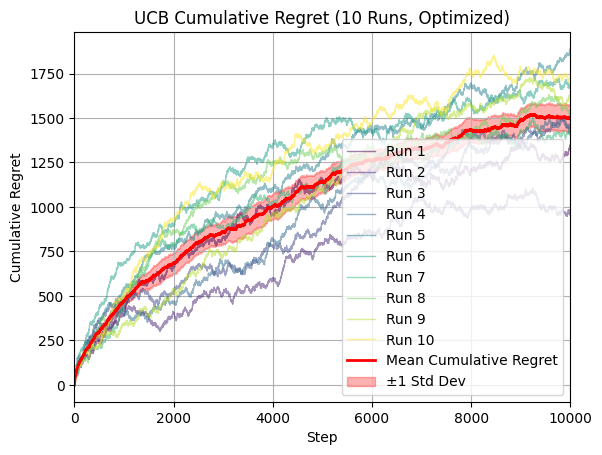

✅ Total execution time: 11.99 seconds


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import time
from joblib import Parallel, delayed  # Optimization 4: Parallel execution

# -----------------------------
# Optimization Summary:
# 1. Avoid repeated log(t)
# 2. Use Welford-style mean update
# 3. Avoid summing all regrets every round
# 4. Use joblib for parallel execution
# 5. Set reproducible random seed
# -----------------------------

# Load preprocessed data
def load_preprocessed_data(save_path="./save"):
    with open(os.path.join(save_path, "rtlr_arms.json"), "r") as f:
        arms = json.load(f)
    with open(os.path.join(save_path, "rtlr_rewards.json"), "r") as f:
        rewards = json.load(f)
    return arms, rewards

# Optimized UCB algorithm
def ucb_bandit(K, n, reward_lists, B, seed_offset=0):
    np.random.seed(42 + seed_offset)
    random.seed(42 + seed_offset)

    empirical_means = np.zeros(K)
    action_counts = np.zeros(K)
    cumulative_regrets = np.zeros(n)

    for t in range(1, n + 1):
        log_t = np.log(t)
        ucb_values = empirical_means + (B / 2) * np.sqrt((4 * log_t) / (action_counts + 1e-5))
        arm = np.argmax(ucb_values)
        reward = random.choice(reward_lists[arm])
        action_counts[arm] += 1

        # Welford-style update (Optimization 2)
        empirical_means[arm] += (reward - empirical_means[arm]) / action_counts[arm]

        # Incremental regret calculation (Optimization 3)
        best_mean = np.max(empirical_means)
        regret = best_mean - reward
        if t == 1:
            cumulative_regrets[t - 1] = regret
        else:
            cumulative_regrets[t - 1] = cumulative_regrets[t - 2] + regret

    return cumulative_regrets

# Parameters
arms, rewards = load_preprocessed_data()
reward_lists = list(rewards.values())
K = len(arms)
B = 5  # Assuming max-min reward range
n = 10000
num_runs = 10

# Record total execution time
start_time = time.time()

# Run in parallel (Optimization 4)
all_cumulative_regrets = Parallel(n_jobs=-1)(
    delayed(ucb_bandit)(K, n, reward_lists, B, run) for run in range(num_runs)
)
all_cumulative_regrets = np.array(all_cumulative_regrets)

# Visualization
colors = plt.cm.viridis(np.linspace(0, 1, num_runs))
for run in range(num_runs):
    plt.plot(all_cumulative_regrets[run], color=colors[run], alpha=0.5, linewidth=1, label=f'Run {run + 1}')

mean_regret = np.mean(all_cumulative_regrets, axis=0)
stderr = np.std(all_cumulative_regrets, axis=0) / np.sqrt(num_runs)

plt.plot(mean_regret, color='red', label='Mean Cumulative Regret', linewidth=2)
plt.fill_between(range(n),
                 mean_regret - stderr,
                 mean_regret + stderr,
                 color='red', alpha=0.3, label='±1 Std Dev')

plt.title('UCB Cumulative Regret (10 Runs, Optimized)')
plt.xlabel("Step")
plt.ylabel("Cumulative Regret")
plt.xlim(0, n)
plt.legend()
plt.grid(True)
plt.show()

end_time = time.time()
print(f"✅ Total execution time: {end_time - start_time:.2f} seconds")

# -------------------------------
# ORIGINAL (UNOPTIMIZED) VERSION:
# -------------------------------
# empirical_means[arm] = (empirical_means[arm] * (action_counts[arm] - 1) + reward) / action_counts[arm]
# cumulative_regrets[t - 1] = np.sum(regrets)
# for run in range(num_runs):
#     cumulative_regrets = ucb_bandit(K, n, reward_lists, B)
#     all_cumulative_regrets[run, :] = cumulative_regrets